In [1]:
import importlib

import common

importlib.reload(common)

<module 'common' from 'C:\\Users\\kamko\\IdeaProjects\\fiit_masters_thesis_project\\jupyter\\common.py'>

In [13]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy

from common import create_engine
from common import display_all
from common import figsize
from common import save_df
from common import load_df


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # converters e.g. for datetime in plots

In [3]:
engine = create_engine('db-conf.json', 'local')
pd.sql = lambda sql: pd.read_sql(sql, con=engine)

In [4]:
monitored_articles = pd.sql('''
SELECT mav.url,
       mav.published_at,
       ff.extracted_at at time zone 'utc'                      as sync_date,
       ff.reaction_count,
       ff.comment_count,
       ff.share_count,
       (ff.reaction_count + ff.comment_count + ff.share_count) as popularity
FROM main_articles_view mav
         JOIN feedback_facebook ff on mav.url = ff.related_object_url;
''')

In [5]:
# add artifical first row for every value where engagement = (0,0,0) and sync_date = published_at
_mart = monitored_articles.copy()
_mart = _mart.sort_values(by=['url', 'sync_date'])
_mart = _mart.groupby('url').first().reset_index()
_mart = _mart.drop_duplicates()

first_rows = []
for row in _mart.itertuples():
    first_rows.append([row.url, row.published_at, row.published_at,  0, 0, 0,  0, False])
    first_rows.append([row.url, row.published_at, row.sync_date, row.reaction_count, row.comment_count, row.share_count, row.popularity, False])
    
monitored_articles_art = monitored_articles.copy()
monitored_articles_art['real_observation'] = True
monitored_articles_art = pd.concat([monitored_articles_art, pd.DataFrame(first_rows, columns=monitored_articles_art.columns)], ignore_index=True)
monitored_articles_art = monitored_articles_art.sort_values(by=['url', 'sync_date', 'real_observation'])
monitored_articles_art['age_hours'] = (monitored_articles_art['sync_date'] - monitored_articles_art['published_at']).apply(lambda x: x.total_seconds() // 3600)

In [6]:
monitored_articles_art

,url,published_at,sync_date,reaction_count,comment_count,share_count,popularity,real_observation,age_hours
4323024,http://blog.healthadvocate.com/2019/10/four-fo...,2019-10-25 04:42:00,2019-10-25 04:42:00.000000,0,0,0,0,False,0.0
4323025,http://blog.healthadvocate.com/2019/10/four-fo...,2019-10-25 04:42:00,2019-10-25 15:06:19.000000,0,0,0,0,False,10.0
1224826,http://blog.healthadvocate.com/2019/10/four-fo...,2019-10-25 04:42:00,2019-10-25 15:06:19.000000,0,0,0,0,True,10.0
1224827,http://blog.healthadvocate.com/2019/10/four-fo...,2019-10-25 04:42:00,2019-10-25 17:06:30.000000,0,0,0,0,True,12.0
1224828,http://blog.healthadvocate.com/2019/10/four-fo...,2019-10-25 04:42:00,2019-10-25 19:06:40.000000,0,0,0,0,True,14.0
...,...,...,...,...,...,...,...,...,...
1203131,https://youngwomenshealth.org/2020/04/06/conti...,2020-04-06 06:00:35,2020-04-07 00:53:52.167384,0,0,2,2,True,18.0
1212010,https://youngwomenshealth.org/2020/04/06/conti...,2020-04-06 06:00:35,2020-04-07 03:11:42.941086,0,0,2,2,True,21.0
1215311,https://youngwomenshealth.org/2020/04/06/conti...,2020-04-06 06:00:35,2020-04-07 05:40:49.796283,0,0,2,2,True,23.0
1219753,https://youngwomenshealth.org/2020/04/06/conti...,2020-04-06 06:00:35,2020-04-07 07:59:01.730115,0,0,2,2,True,25.0


In [7]:
def sample_articles(data, size, random_state=None):
    urls = pd.Series(monitored_articles_art.url.unique()).sample(n=size, random_state=random_state)
    return monitored_articles_art[monitored_articles_art.url.isin(urls)].copy()

def plot_engagement(data, yscale, extra_fgrid_args=None, extra_sns_args=None, vertical_lines_at=None):
    if extra_fgrid_args is None:
        extra_fgrid_args = {}
    
    if extra_sns_args is None:
        extra_sns_args = {}
    
    if vertical_lines_at is None:
        vertical_lines_at = []

    min_time = 0
    fgrid = sns.relplot(data=data,
                x='age_hours', y='popularity',
                hue='url', style='real_observation', style_order=[True, False],
                kind='line', height=12, aspect=1,
                legend=False,
                **extra_sns_args)
    fgrid.set(xlim=(min_time, None))
    fgrid.set(**extra_fgrid_args)
    fgrid.axes[0][0].set_yscale(**yscale)

    for ax in fgrid.axes.flat:
        for i in vertical_lines_at:
            ax.axvline(i)
    
    return fgrid

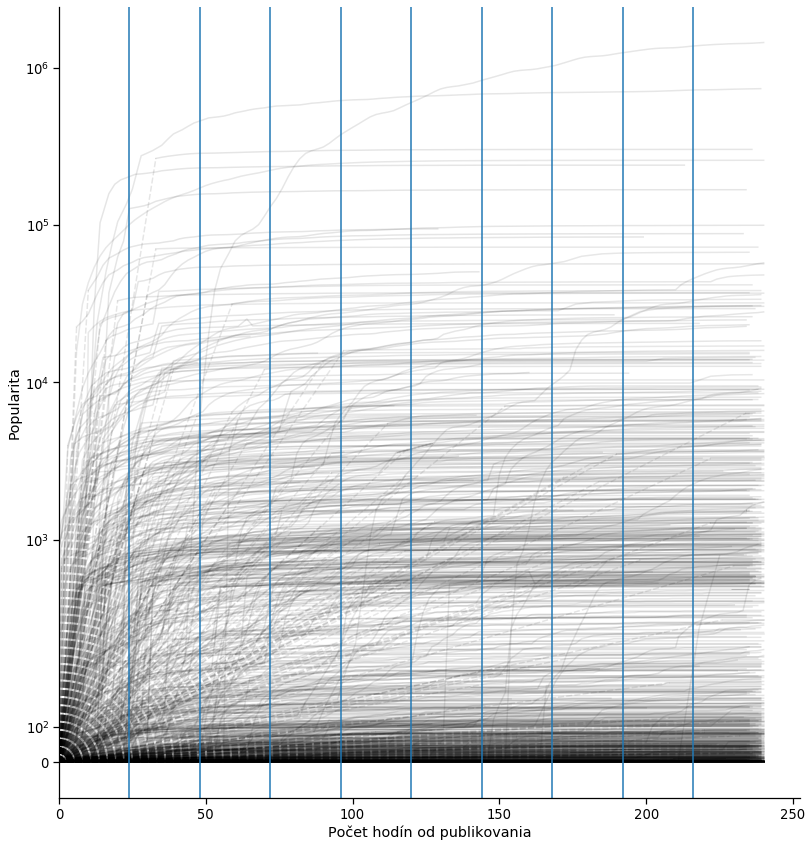

In [10]:
sample_size = 1250
monitored_articles_art = monitored_articles_art[monitored_articles_art.age_hours <= 10*24]
sampled_articles = sample_articles(data=monitored_articles_art, size=sample_size, random_state=444)
palette = sns.dark_palette(color='black', n_colors=sample_size)

with sns.plotting_context("notebook", font_scale=1.2):
    eng_plot = plot_engagement(sampled_articles,
                        yscale={'value': 'symlog', 'linthreshy': 500},
                        extra_sns_args={'palette': palette, 'alpha': 0.1},
                        vertical_lines_at=list(range(0, 10*24, 24)))

eng_plot.set_axis_labels('Počet hodín od publikovania', 'Popularita')
eng_plot.savefig('export/popularity-vyvoj.png')

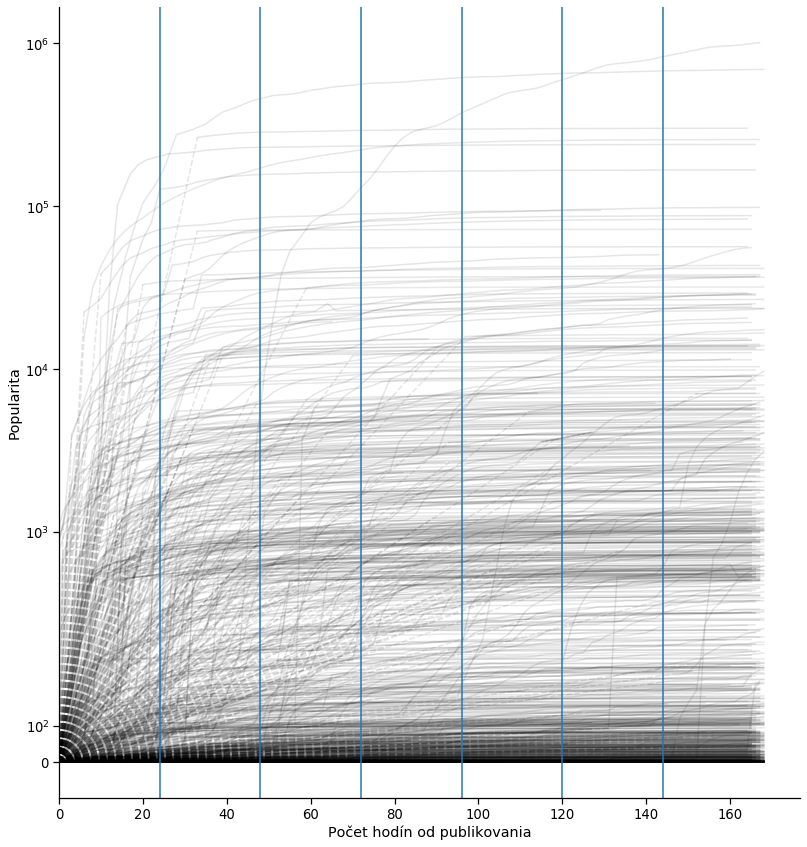

In [11]:
sample_size = 1250
monitored_articles_art = monitored_articles_art[monitored_articles_art.age_hours <= 7*24]
sampled_articles = sample_articles(data=monitored_articles_art, size=sample_size, random_state=444)
palette = sns.dark_palette(color='black', n_colors=sample_size)

with sns.plotting_context("notebook", font_scale=1.2):
    eng_plot = plot_engagement(sampled_articles,
                        yscale={'value': 'symlog', 'linthreshy': 500},
                        extra_sns_args={'palette': palette, 'alpha': 0.1},
                        vertical_lines_at=list(range(0, 7*24, 24)))

eng_plot.set_axis_labels('Počet hodín od publikovania', 'Popularita')
eng_plot.savefig('export/popularity-vyvoj-kratsie.png')